# Model4
model gpu version

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Wed Feb 28 04:50:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Installs the **current stable version** of RAPIDSAI's core libraries using pip, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. xgboost

**This will complete in about 3-4 minutes**

Please use the [RAPIDS Conda Colab Template notebook](https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9) if you need to install any of RAPIDS Extended libraries, such as:
- cuSpatial
- cuSignal
- cuxFilter
- cuCIM

OR
- nightly versions of any library


In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 460 (delta 131), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (460/460), 126.19 KiB | 1.00 MiB/s, done.
Resolving deltas: 100% (233/233), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.8 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.2.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.7/464.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 953.

# RAPIDS is now installed on Colab.  
You can copy your code into the cells below or use the below to validate your RAPIDS installation and version.  
# Enjoy!

In [3]:
import cudf
cudf.__version__

'24.02.02'

In [4]:
import cuml
cuml.__version__

'24.02.00'

In [5]:
import cugraph
cugraph.__version__

'24.02.00'

In [6]:
import cupy as cp
cp.__version__

'13.0.0'

# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pandas as pd
from scipy import stats
from tqdm import tqdm
from collections import namedtuple
from cuml.svm import SVR
from cuml.linear_model import Ridge
from cuml.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from cuml.model_selection import GridSearchCV
from sklearn.model_selection import KFold, train_test_split, learning_curve
from cuml import metrics

In [ ]:
# @title Original function
def pooling(df,spl = 10): # 列方向に平均化
  col = np.arange(int(df.shape[1]/spl))*spl
  pool_val = [];col_ = []
  for i in range(len(col[:-1])):
    pool_val.append(df.values[:, col[i]:col[i+1]].mean(1))
    col_.append(np.mean(df.columns[col[i]:col[i+1]].astype('float64')))
  pool_val.append(df.values[:, col[-1]:].mean(1))
  col_.append(np.mean(df.columns[col[-1]:].astype('float64')))
  return pd.DataFrame(np.array(pool_val).T,columns = col_,index = df.index)

def train_(X,y,model,cv = 10,label = 'aBMD $[g/cm^2]$'):
  res_pred = np.zeros_like(y);r2_add=[]
  cv = KFold(n_splits=cv, shuffle=True, random_state=1234)
  for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    res_pred[test_index] = pred
    print('r2 = ', metrics.r2_score(y_test,pred))
    r2_add.append(metrics.r2_score(y_test,pred))
  print('All r2 = ', metrics.r2_score(y,res_pred))
  print('Mean r2 = ', round(np.mean(r2_add),5),'±', round(np.std(r2_add),5))
  showGraph(y,res_pred,label = label,dpi=100)
  return res_pred, metrics.r2_score(y,res_pred)

def showGraph(y,res_pred,label = 'aBMD $[g/cm^2]$',dpi=100,figsize =(4,4)):
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot(y,res_pred,'.' ,c = 'k')
  correlationLine(y,res_pred,score = 'r2')
  plt.legend(edgecolor='none')
  plt.xlabel('Reference '+label)
  plt.ylabel('Predicted '+label)
  plt.show()
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot((y+res_pred)/2,y-res_pred,'.' ,c = 'k')
  max_ = max((y+res_pred)/2)
  min_ = min((y+res_pred)/2)
  mean_ = np.mean(y-res_pred)
  upp_ = mean_+1.96*np.std(y-res_pred)
  low_ = mean_-1.96*np.std(y-res_pred)
  plt.plot([min_,max_],[mean_,mean_],':',c = 'k')
  plt.plot([min_,max_],[upp_,upp_],'-.',c = 'k')
  plt.plot([min_,max_],[low_,low_],'-.',c = 'k')
  correlationLine((y+res_pred)/2,y-res_pred)
  plt.legend(edgecolor='none')
  label_ = 'Mean of predicted and reference '+label
  plt.xlabel(label_)
  label_ = 'Difference between \n predicted and reference '+label
  plt.ylabel(label_)
  plt.show()
  print('loa_upper: ',round(upp_,5))
  print('loa_lower: ',round(low_,5))
  print("Mean: ",mean_)

def correlationLine(x,y,score = 'r'):
  x = np.array(x).flatten()
  y = np.array(y).flatten()
  #相関
  if score =='r':
    slope, intercept, r_value, _, _ = stats.linregress(x,y)
    r, p = stats.pearsonr(x,y)
    print(stats.spearmanr(x,y))
    label_ = "r = "+str(round(r_value,3))
  if score == 'r2':
    r_value = metrics.r2_score(x,y)
    label_ = "$r^2$ = "+str(round(r_value,3))
    print('pearsonr:',stats.pearsonr(x,y))
  ysub = np.poly1d(np.polyfit(x,y,1))(x)
  xx = [x.min(),x.max()]
  yy = [ysub.min(),ysub.max()]
  if r_value < 0:
    yy = [ysub.max(),ysub.min()]
  plt.plot(xx,yy,"--",color="0.2",label = label_)

def plot_learning_curve(X, y, model, cv=10):
  train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                          X=X, y=y, scoring='r2',
                                                          cv=cv, n_jobs=-1)
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)
  plt.figure()
  plt.plot(train_sizes, train_mean, marker='o', label='Train score')
  plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.2)
  plt.plot(train_sizes, test_mean, marker='s', linestyle='--', label='Validation score')
  plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.2)
  plt.grid()
  plt.xlabel('Number of samples in training set')
  plt.ylabel('$r^2$')
  plt.legend()
  plt.show()

In [ ]:
version = "ellipse"
path = f"/content/drive/MyDrive/Tamura/ML/{version}/dataset/"

files = glob.glob(f"{path}opt_result/*.csv")
sim_params = pd.read_csv(f"{path}params.csv", index_col=0)
len(files)

In [ ]:
def process(df, window, spl, step):
  df_1 = df.rolling(window, axis=1).mean().dropna(axis=1)
  df_2 = pooling(df_1, spl=spl)
  df_3 = df_2[::step]
  data = np.log(df_3.values + 1).flatten()
  return data

In [ ]:
nn = 1211
spl = 25; window = 20; step = 3

dataset = pd.DataFrame()
for i in tqdm(range(nn)):
  df = pd.read_csv(files[i], index_col=0).fillna(0)
  data = process(df, window, spl, step)

  filename = files[i].split('/')[-1].split('.')[0]
  target = sim_params[sim_params["filename"]==filename]["aBMD"]
  subset = pd.Series(np.append(data, target), name=filename, index=[f"var{i}" for i in range(data.size)]+["target"])
  dataset = pd.concat([dataset, subset.to_frame().T])
dataset.head()

In [ ]:
features = dataset.drop('target',axis=1).columns
X = dataset[features].values.astype("float32")
X = (X - X.mean(0)) / X.std(0)
y = dataset.target.values.astype("float32")

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
# @title Random Forest
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RF",
        RandomForestRegressor(),
      {"n_estimators": [10, 20, 50, 100, 300],
       "max_features": ["log2", "sqrt", 1.0],
       "max_depth": [10, 20, 30, 40, 50],
       })

In [ ]:
# @title Gradient Tree Boosting
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("GTB",
        XGBRegressor(tree_method="hist", device="cuda"),
        {"n_estimators": [10, 20, 50, 100, 300],
         "max_depth": [1, 2, 3, 4, 5],
         "eta": [0.001, 0.01, 0.1, 1.0, 10],
         })

In [ ]:
# @title Support Vector Machine
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("SVM",
        SVR(),
       {"kernel": ["rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
        })

In [ ]:
# @title Ridge Regressor
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RR",
        Ridge(),
       {"alpha": [0.001, 0.01, 0.1, 1.0, 10],
        "fit_intercept": [True, False]
        })

In [ ]:
grid_search = GridSearchCV(ml.model, ml.params, cv=10, scoring='r2')
grid_search.fit(X_train_val, y_train_val)
print(f"Model: {ml.model}")
print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
print(f"Test score: {grid_search.score(X_test, y_test)}")

In [ ]:
result = {}

In [ ]:
ml.model.set_params(**grid_search.best_params_)
pred_, r2 = train_(X, y, ml.model, cv=10, label="aBMD $[g/cm^2]$")
result[ml.name] = r2

In [ ]:
tmp = {'reference aBMD': y,
       'predicted aBMD': pred_}
df = pd.DataFrame(tmp)

path = f"/content/drive/MyDrive/Tamura/ML/{version}/result/"
df.to_csv(f"{path}R1_RR.csv")

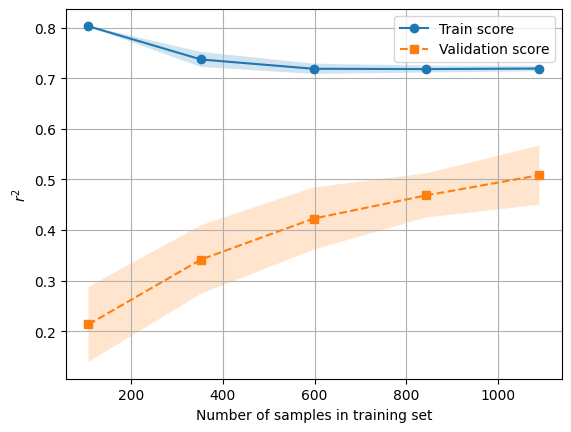

In [ ]:
plot_learning_curve(X, y, ml.model)

In [ ]:
df = pd.DataFrame(result, index=['r2'])
df

In [ ]:
path = f"/content/drive/MyDrive/Tamura/ML/{version}/result/"

f_num = len(glob.glob(f"{path}*.csv"))
df.to_csv(f"{path}result{f_num + 1}.csv")